<a href="https://colab.research.google.com/github/UN-GCPDS/Curso-Corto-LLMs/blob/main/3.%20Dashboard/Ejemplo%20LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo UNAL CHEC](https://github.com/UN-GCPDS/curso_IA_CHEC/blob/main/logo_unal_chec.jpg?raw=1)

# **Ejemplo LLM**



### **Profesor - Sesión 1:** Andrés Marino Álvarez Meza y Diego Armando Pérez Rosero

## INSTALAMOS DEPENDENCIAS

In [1]:
%%capture
!pip install langchain #### LANGCHAIN APROVECHAR LA INFORMACIÓN DATA NO ESTRUCTURA
!pip install openai #### MODELO DE LENGUAJE
!pip install chroma #### LUGAR / BASE DE DATOS VECTORIZADA
!pip install chromadb
!pip install langchain_community
!pip install tiktoken
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install PyPDF2 Pillow
!pip install pdf2image
!sudo apt install poppler-utils
!sudo apt install tesseract-ocr-spa
!tesseract -l spa
!pip install pymupdf
!pip install langchain-experimental
!git clone https://github.com/UN-GCPDS/Curso-Corto-LLMs
!pip install langchain-openai

In [2]:
%%capture
!pip install httpx==0.27.2

## IMPORTAMOS DEPENDENCIAS

In [3]:
from langchain_community.document_loaders import Docx2txtLoader #To load word files
from langchain.document_loaders import PyPDFLoader #To load pdf files
from langchain.vectorstores import Chroma #Vectorial DataBase
from langchain.embeddings.openai import OpenAIEmbeddings #Word2Vec Model to tokenizer the text
from langchain.text_splitter import RecursiveCharacterTextSplitter #To splitt the text
from langchain.chat_models import ChatOpenAI #To load LLM from OPENAI
from langchain.chains import RetrievalQA #To build chains to QA tasks
from langchain import PromptTemplate #Class that allow the before to get in in production
from langchain.chains.summarize import load_summarize_chain #To buil chains to summarize tasks
import os
from langchain.vectorstores import Chroma #The vectorial database
from langchain_community.document_loaders import TextLoader
from langchain_community.document_loaders import TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter #To splitt the text
from langchain.embeddings.openai import OpenAIEmbeddings #Word2Vec Model to tokenizer the text
from langchain.vectorstores import Chroma #The vectorial database
from langchain.prompts import PromptTemplate
from langchain.memory import ConversationBufferMemory
from langchain_community.chat_models import ChatOpenAI
from langchain.chains.question_answering import load_qa_chain
import PyPDF2
from PIL import Image
import io
from pdf2image import convert_from_path
import cv2
import os

In [4]:
import pandas as pd

## DEFINIMOS FUNCIONES PARA EL EJERCICIO

In [5]:
from pathlib import Path

# LangChain loaders
from langchain_community.document_loaders import TextLoader
# Preferimos PyMuPDF por velocidad/robustez; si no está, caemos a PyPDFLoader
try:
    from langchain_community.document_loaders import PyMuPDFLoader as _PDFLoader
except Exception:
    from langchain_community.document_loaders import PyPDFLoader as _PDFLoader

# Para PDFs escaneados (OCR). Requiere: pip install "unstructured[pdf]" pytesseract
# from langchain_community.document_loaders import UnstructuredPDFLoader

def load_docs_any(root_path: str):
    """
    Carga .txt y .pdf como lista de langchain.schema.Document.
    - Para .pdf: devuelve un Document por página (loader por defecto en PyMuPDF/PyPDF).
    - Para .txt: un solo Document por archivo.
    """
    path = Path(root_path)
    docs = []

    def _load_one(file_path: Path):
        if file_path.suffix.lower() == ".pdf":
            loader = _PDFLoader(str(file_path))      # Para OCR usar: UnstructuredPDFLoader(str(file_path))
        elif file_path.suffix.lower() in [".txt", ".md"]:
            loader = TextLoader(str(file_path), encoding="utf-8")
        else:
            return []  # ignora otras extensiones
        return loader.load()

    if path.is_dir():
        # Busca recursivamente PDFs y TXTs
        files = list(path.rglob("*.pdf")) + list(path.rglob("*.txt")) + list(path.rglob("*.md"))
        for f in files:
            try:
                docs.extend(_load_one(f))
                print(f"CARGADO: {f}")
            except Exception as e:
                print(f"ERROR en {f}: {e}")
    else:
        # Ruta a un solo archivo
        try:
            docs.extend(_load_one(path))
            print(f"CARGADO: {path}")
        except Exception as e:
            print(f"ERROR en {path}: {e}")

    print(f"TOTAL DOCUMENTOS: {len(docs)}")
    return docs

# Si quieres mantener tu nombre:
def txt_to_langchain(root_path):
    # Ahora también acepta PDF :)
    return load_docs_any(root_path)



def get_vdb(concatenated_files):
    #SPLITTING THE TEXTS:
    print("EMPEZANDO A LLEVAR A UNA BASE DE DATOS VECTORIZADA")
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1500, #Fragments of text of 1500 tokens
        chunk_overlap=200, #For evey fragment that take the 200 last tokens of the last fragment
        length_function=len
        )
    documents = text_splitter.split_documents(concatenated_files) #List with the metadata and the content splitt by fragments of 1500 tokens

    print("OBTENIENDO LISTA DE DOCUMENTOS VECTORIZADA: ",documents)
    #CARRY THE CONTENT OF THE DOCUMENTS TO A VECTORIAL DATABASE:
    #------------------------------------------------------------
    #------------------------------------------------------------
    embeddings = OpenAIEmbeddings(model="text-embedding-ada-002") #word2vec model of openAI
    print("OBTENEMOS EL MODELO DE EMBEDDING")
    NOMBRE_INDICE_CHROMA = f"vdb_{'6'}" #Name of my vectorial database (Put the name that you want)

    print("VECTORIZANDO")
    #Creating our vectorial database or vector store
    vectorstore_chroma = Chroma.from_documents(
        documents=documents, #Create the database with the list of the created documents (Every instance will be the embedding of every document)
        embedding=embeddings, #, #Word2vec model to create our embeddings, always use the same.
        persist_directory=NOMBRE_INDICE_CHROMA #Load my database in the indicated folder (If I close the section, I will keep storaged my vectorial databas in the folder called "NOMBRE_INDICE_CHROMA" )
    )
    print("VECTORIZADO")
    #loaded_
    #loaded_database = Chroma(persist_directory=f"AzureStorage/CerebroAuditoria/temporal_databases/vdb_{cont}",embedding_function=embeddings)

    return vectorstore_chroma

## CONFIGURAMOS LAS CREDENCIALES DE OPEN_AI

In [10]:
OPENAI_API_KEY = "xxxxxx"
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

## APLICACIÓN PRINCIPAL

CREAMOS LA BASE DE DATOS Y LE SUBIMOS LA INFORMACIÓN BASE DE CADA TIPO DE FALLA O EVENTO

In [11]:
path = "/content/Curso-Corto-LLMs/3. Dashboard/Descripción.pdf"
codificate_pages = txt_to_langchain(path) ## LLEVAMOS LOS DOCUMENTOS AL FORMATOR REQUERIDO POR LANGCHAIN Y CHROMA

CARGADO: /content/Curso-Corto-LLMs/3. Dashboard/Descripción.pdf
TOTAL DOCUMENTOS: 2


In [12]:
codificate_pages

[Document(metadata={'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2025-09-18T20:57:17-05:00', 'source': '/content/Curso-Corto-LLMs/3. Dashboard/Descripción.pdf', 'file_path': '/content/Curso-Corto-LLMs/3. Dashboard/Descripción.pdf', 'total_pages': 2, 'format': 'PDF 1.7', 'title': '', 'author': 'UNALMAN', 'subject': '', 'keywords': '', 'moddate': '2025-09-18T20:57:17-05:00', 'trapped': '', 'modDate': "D:20250918205717-05'00'", 'creationDate': "D:20250918205717-05'00'", 'page': 0}, page_content='Las fallas en redes de distribución de energía eléctrica deben ser gestionadas de acuerdo \ncon la regulación vigente, principalmente la Resolución CREG 070 de 1998, que \nestablecen estándares técnicos para garantizar la calidad del servicio. \n \nA continuación, se describen las fallas indicadas en el contexto técnico y operativo: \n \n1. Arco reventado o suelto \n \nDescripción: Un arco eléctrico ocurre cuando hay una descarga de corriente entre dos \n

CREAMOS LA BASE DE DATOS VECTORIZADA

In [13]:
chroma_db = get_vdb(codificate_pages)

EMPEZANDO A LLEVAR A UNA BASE DE DATOS VECTORIZADA
OBTENIENDO LISTA DE DOCUMENTOS VECTORIZADA:  [Document(metadata={'producer': 'Microsoft® Word 2019', 'creator': 'Microsoft® Word 2019', 'creationdate': '2025-09-18T20:57:17-05:00', 'source': '/content/Curso-Corto-LLMs/3. Dashboard/Descripción.pdf', 'file_path': '/content/Curso-Corto-LLMs/3. Dashboard/Descripción.pdf', 'total_pages': 2, 'format': 'PDF 1.7', 'title': '', 'author': 'UNALMAN', 'subject': '', 'keywords': '', 'moddate': '2025-09-18T20:57:17-05:00', 'trapped': '', 'modDate': "D:20250918205717-05'00'", 'creationDate': "D:20250918205717-05'00'", 'page': 0}, page_content='Las fallas en redes de distribución de energía eléctrica deben ser gestionadas de acuerdo \ncon la regulación vigente, principalmente la Resolución CREG 070 de 1998, que \nestablecen estándares técnicos para garantizar la calidad del servicio. \n \nA continuación, se describen las fallas indicadas en el contexto técnico y operativo: \n \n1. Arco reventado o sue

## LEEMOS LA BASE DE DATOS DE COMENTARIOS

In [14]:
eventos = pd.read_excel('/content/Curso-Corto-LLMs/3. Dashboard/Eventos_1_Semestre2024.xlsx')

In [15]:
eventos.head(4)

,EVENTO,ODT_BIT,CIRCUITO,EQUIPO_OPE,ELEM_OPERADO,TIPO_CAUSA,CAUSA_SGO,INICIO,FIN,HRS,#TRAFOS,#USUARIOS,EJECUTANDOSE,EJECUTADA
0,8258065,935773,AZA30L12,PSO30L13,33,No programada,Falla en redes de distribución y elementos aso...,2024-05-19 13:52:16,2024-05-19 13:52:26,0.00,1637,51133,09:07: CARLOS SIERRA INFORMA QUE REPARARON ARC...,\nREPARAN ARCO VOLADO EN EL B14023 Y CAMBIAN 2...
1,8261543,38887,IRR30L14,IRR30L14,33,No programada,Condiciones atmosféricas,2024-05-28 00:55:26,2024-05-28 00:56:29,0.02,2150,47288,-,"Disparo circuitos 33Kv, Normal por ensayo"
2,8259334,936128,ROS30T21,ROS30T21,TFP,No programada,Afectación por fallas en redes de otros OR,2024-05-22 16:45:14,2024-05-22 16:47:30,0.04,663,32473,12:00 SE REALIZA REPARACION DE LA LINEA PRIMAR...,\n12:00 SE REALIZA REPARACION DE LA LINEA PRIM...
3,8261569,38889,IRR40L18,IRR40L18,115,Excluible,Apertura en redes del SDL por causa de equipos...,2024-05-28 01:19:57,2024-05-28 01:21:35,0.03,969,31360,-,01:19 a 01:21 Disparo de la bahia de linea 115...


unificamos los campos de texto para pasarlas dentro del contexto de la pregunta

In [16]:
import re

In [17]:
# Paso 1: Unificar las 3 columnas separadas por espacio
eventos['texto unificado'] = eventos['CAUSA_SGO'] + ' ' + eventos['EJECUTANDOSE'] + ' ' + eventos['EJECUTADA']

# Paso 2: Preprocesar para eliminar las horas en formato HH:MM
# Usamos una expresión regular para eliminar las horas
eventos['texto unificado'] = eventos['texto unificado'].apply(lambda x: re.sub(r'\b\d{1,2}:\d{2}\b', '', x))
# Expresión regular para eliminar horas (HH:MM), fechas (YYYY-MM-DD), "/", y etiquetas HTML
eventos['texto unificado'] = eventos['texto unificado'].apply(lambda x: re.sub(r'\b\d{1,2}:\d{2}\b', '', x))  # Eliminar horas
eventos['texto unificado'] = eventos['texto unificado'].apply(lambda x: re.sub(r'\d{4}-\d{2}-\d{2}', '', x))  # Eliminar fechas
eventos['texto unificado'] = eventos['texto unificado'].apply(lambda x: re.sub(r'/', '', x))  # Eliminar "/"
eventos['texto unificado'] = eventos['texto unificado'].apply(lambda x: re.sub(r'<.*?>', '', x))  # Eliminar etiquetas HTML

In [18]:
eventos.head(10)['texto unificado']

,texto unificado
0,Falla en redes de distribución y elementos aso...
1,Condiciones atmosféricas - Disparo circuitos 3...
2,Afectación por fallas en redes de otros OR SE...
3,Apertura en redes del SDL por causa de equipos...
4,Condiciones atmosféricas - \n\n\nevento simult...
5,Proyectos de adecuaciones y traslado de infrae...
6,Apertura en redes del SDL por causa de equipos...
7,Apertura en redes del SDL por causa de equipos...
8,Causa desconocida el encargado de la odo solic...
9,Causa desconocida el encargado de la odo solic...


In [19]:
eventos.head(10)['texto unificado'].iloc[0]

'Falla en redes de distribución y elementos asociados : CARLOS SIERRA INFORMA QUE REPARARON ARCO REVENTADO EN EL B14023 Y CAMBIARON 2 CONECTORES DE RANURA PARALELA, SOLICITAN DESATERRIZAR ENE-AZA 2, MIENTRAS CIERRAN CORTE VISIBLE EN COCA-COLA.\n: DESATERRIZADO ENE-AZA 2.\nCERRADAS LINEAS AZA-ENE 1 Y 3.Usuario  Fecha: juan carlos ortegon nunez    :08: CARLOS SIERRA INFORMA QUE TIENEN TENSION EN LA LINEA ENE30L16 EN EL B14023 DONDE HAY ARCO REVENTADO, POR LO CUAL SOLICITAN ABRIR AMBOS EXTREMOS ENA-AZA 1 Y 3; SE CONSULTA CON INGO MANUEL USCATEGUI QUIEN APRUEBA LAS MANIOBRAS, INDICA CARLOS SIERRA QUE DEMORAN MAS O MENOS UNA HORA REPARANDO EL DA?O YA QIE TAMBIEN VAN A CAMBIAR ALGUNOS AISLADORES QUE OBSERVAN DEFECTUOSOS.Usuario  Fecha: juan carlos ortegon nunez    :39SE REALIZA APERTURA DE LAS CUCHILLAS B15173 SE REALIZA NUEVAMENTE ENSAYO Y CIERRA NORMAL AL MOMENTO DE CERRAR LA TOPOLOGIA HACE UNA EXPLOSION QUEDA PENDIENTE PARA MA?ANA REVISAR LA ESTRUCTURA AISLADORES Y PARARRAYOS Usuario  Fec

mirar como pulir los elementos que le suministrar al modelo de lenguaje

## DEFINIMOS EL TEMPLATE PARA EL MODELO DE LENGUAJE

In [20]:
def makeQuestion(chroma_Db, event_comment):
    template = """
    Eres un experto técnico en infraestructura eléctrica. Tu objetivo es responder a las preguntas basado en el docuemento proporcionado.
    Si en el contexto proporcionado no está la respuesta a la pregunta hecha por el usuario, no inventes.

    {context}

    {chat_history}
    Human: {human_input}
    Chatbot (Responde de una manera formal):
    """
    question = "Teniendo en cuenta los tipos de fallas en el contexto técnico y operativo, y el comentario que se encuentra al final, asociado a una falla presentada dime en cual de las categorias encaja mejor, dame la respuesta siempre iniciando con la frase La falla presentada en el comentario encaja mejor en la categoría de y con la categoria entre comillas, con eso presente este es el comentario : "+ event_comment

    prompt = PromptTemplate(
    input_variables=["chat_history", "human_input", "context"], template=template
    )

    ### CONFIGURAMOS EL MODELO DE LENGUAJE
    memory = ConversationBufferMemory(memory_key="chat_history", input_key="human_input")
    chain = load_qa_chain(
    ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0), chain_type="stuff", memory=memory, prompt=prompt
    )

    docs=chroma_Db.similarity_search(question,k=6)
    response=chain({"input_documents": docs, "human_input": question, "chat_history":memory}, return_only_outputs=False)['output_text'] #AI answer
    return response


def getDataExpresion(response):
   # Expresión regular para extraer lo que está entre comillas
   resultado = re.findall(r'"([^"]*)"', response)
   return resultado

Probamos la pregunta

In [21]:
comentario =  eventos.head(10)['texto unificado'].iloc[0]
respuesta = makeQuestion(chroma_db, comentario)

/tmp/ipython-input-825284019.py:19: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="chat_history", input_key="human_input")
/tmp/ipython-input-825284019.py:21: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0), chain_type="stuff", memory=memory, prompt=prompt
/tmp/ipython-input-825284019.py:20: LangChainDeprecationWarning: This class is deprecated. See the following migration guides for replacements based on `chain_type`:
stuff: https://python.langchain.com/docs/versions/migrating_chains/stuff_docs_chain
map_reduce: h

PUEDO EXTRAER POR EXPRESIONES REGULARES LA CATEGORIA UNICAMENTE

In [22]:
respuesta

'La falla presentada en el comentario encaja mejor en la categoría de "Arco reventado".'

In [23]:
category = getDataExpresion(respuesta)

In [24]:
category

['Arco reventado']

## HACEMOS UN PROCESO ITERATIVO DE TODO EL ARCHIVO DE EXCEL Y LO AGREGAMOS COMO UNA NUEVA COLUMNA

In [25]:
def getClassFunction(text):
    respuesta = makeQuestion(chroma_db, text)

    category = getDataExpresion(respuesta)

    return {'categoria':category[0],'respuesta':respuesta}

tomando una muestra de los primeros 30 eventos

In [26]:
eventos_muestras = eventos.head(15)

In [27]:
# Aplicar la función a cada fila de la columna y guardar en una lista
resultados = eventos_muestras['texto unificado'].apply(getClassFunction).tolist()

In [28]:
resultados

[{'categoria': 'Arco reventado',
  'respuesta': 'La falla presentada en el comentario encaja mejor en la categoría de "Arco reventado".'},
 {'categoria': 'Disparo',
  'respuesta': 'La falla presentada en el comentario encaja mejor en la categoría de "Disparo".'},
 {'categoria': 'Arco reventado o suelto',
  'respuesta': 'La falla presentada en el comentario encaja mejor en la categoría de "Arco reventado o suelto".'},
 {'categoria': 'Descarga',
  'respuesta': 'La falla presentada en el comentario encaja mejor en la categoría de "Descarga".'},
 {'categoria': 'Descarga',
  'respuesta': 'La falla presentada en el comentario encaja mejor en la categoría de "Descarga".'},
 {'categoria': 'Disparo',
  'respuesta': 'La falla presentada en el comentario encaja mejor en la categoría de "Disparo".'},
 {'categoria': 'Disparo',
  'respuesta': 'La falla presentada en el comentario encaja mejor en la categoría de "Disparo".'},
 {'categoria': 'Disparo',
  'respuesta': 'La falla presentada en el comenta

In [29]:
# Crear un DataFrame a partir de la lista
df_results = pd.DataFrame(resultados)
df_results

,categoria,respuesta
0,Arco reventado,La falla presentada en el comentario encaja me...
1,Disparo,La falla presentada en el comentario encaja me...
2,Arco reventado o suelto,La falla presentada en el comentario encaja me...
3,Descarga,La falla presentada en el comentario encaja me...
4,Descarga,La falla presentada en el comentario encaja me...
5,Disparo,La falla presentada en el comentario encaja me...
6,Disparo,La falla presentada en el comentario encaja me...
7,Disparo,La falla presentada en el comentario encaja me...
8,Disparo,La falla presentada en el comentario encaja me...
9,Disparo,La falla presentada en el comentario encaja me...


se lo agregamos al dataframe de eventos_muestras

In [30]:
eventos_muestras['tipo_falla'] = df_results['categoria']
eventos_muestras['justificacion'] = df_results['respuesta']

/tmp/ipython-input-249328833.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eventos_muestras['tipo_falla'] = df_results['categoria']
/tmp/ipython-input-249328833.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eventos_muestras['justificacion'] = df_results['respuesta']


In [31]:
eventos_muestras.head(5)

,EVENTO,ODT_BIT,CIRCUITO,EQUIPO_OPE,ELEM_OPERADO,TIPO_CAUSA,CAUSA_SGO,INICIO,FIN,HRS,#TRAFOS,#USUARIOS,EJECUTANDOSE,EJECUTADA,texto unificado,tipo_falla,justificacion
0,8258065,935773,AZA30L12,PSO30L13,33,No programada,Falla en redes de distribución y elementos aso...,2024-05-19 13:52:16,2024-05-19 13:52:26,0.00,1637,51133,09:07: CARLOS SIERRA INFORMA QUE REPARARON ARC...,\nREPARAN ARCO VOLADO EN EL B14023 Y CAMBIAN 2...,Falla en redes de distribución y elementos aso...,Arco reventado,La falla presentada en el comentario encaja me...
1,8261543,38887,IRR30L14,IRR30L14,33,No programada,Condiciones atmosféricas,2024-05-28 00:55:26,2024-05-28 00:56:29,0.02,2150,47288,-,"Disparo circuitos 33Kv, Normal por ensayo",Condiciones atmosféricas - Disparo circuitos 3...,Disparo,La falla presentada en el comentario encaja me...
2,8259334,936128,ROS30T21,ROS30T21,TFP,No programada,Afectación por fallas en redes de otros OR,2024-05-22 16:45:14,2024-05-22 16:47:30,0.04,663,32473,12:00 SE REALIZA REPARACION DE LA LINEA PRIMAR...,\n12:00 SE REALIZA REPARACION DE LA LINEA PRIM...,Afectación por fallas en redes de otros OR SE...,Arco reventado o suelto,La falla presentada en el comentario encaja me...
3,8261569,38889,IRR40L18,IRR40L18,115,Excluible,Apertura en redes del SDL por causa de equipos...,2024-05-28 01:19:57,2024-05-28 01:21:35,0.03,969,31360,-,01:19 a 01:21 Disparo de la bahia de linea 115...,Apertura en redes del SDL por causa de equipos...,Descarga,La falla presentada en el comentario encaja me...
4,8263163,937158,HER30T16,HER30T16,TFP,No programada,Condiciones atmosféricas,2024-06-01 16:53:21,2024-06-01 16:57:31,0.07,725,30186,-,\n\n\nevento simultaneo de los interruptores B...,Condiciones atmosféricas - \n\n\nevento simult...,Descarga,La falla presentada en el comentario encaja me...


nos quedamos unicamente con los campos relevantes

In [32]:
# Seleccionar solo las columnas 'categoria' y 'respuesta'
eventos_muestras_filtered = eventos_muestras[['EVENTO','CIRCUITO','tipo_falla','justificacion']]
eventos_muestras_filtered.shape

(15, 4)

In [33]:
import pandas as pd
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
from langchain_openai import OpenAI
from langchain_community.chat_models import ChatOpenAI
import os

In [34]:
agent = create_pandas_dataframe_agent(
        ChatOpenAI(temperature=0, model="gpt-3.5-turbo"),
        eventos_muestras_filtered,
        verbose=True,
        agent_type="openai-functions",#prefix=descripcion_df,  # Añade la descripción al inicio del prompt #suffix=suffix_instrucciones.format(path_plot=path_plot),
        allow_dangerous_code=True,
        include_df_in_prompt=True,  # Incluye las primeras filas del DataFrame en el prompt
        number_of_head_rows=5)

query="Cuantos registros hay por tipo de falla"
response=agent.invoke(query)["output"]



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "df['tipo_falla'].value_counts()"}`


tipo_falla
Disparo                    11
Descarga                    2
Arco reventado              1
Arco reventado o suelto     1
Name: count, dtype: int64Hay 11 registros de tipo "Disparo", 2 registros de tipo "Descarga", 1 registro de tipo "Arco reventado" y 1 registro de tipo "Arco reventado o suelto".

> Finished chain.


In [35]:
response

'Hay 11 registros de tipo "Disparo", 2 registros de tipo "Descarga", 1 registro de tipo "Arco reventado" y 1 registro de tipo "Arco reventado o suelto".'



> Entering new AgentExecutor chain...

Invoking: `python_repl_ast` with `{'query': "import matplotlib.pyplot as plt\nimport pandas as pd\n\n# Calcular la cantidad de registros por tipo de falla\ncounts = df['tipo_falla'].value_counts()\n\ncolors = ['#4CAF50', '#9E9E9E', '#689F38', '#BDBDBD']\n\n# Crear el gráfico de barras\ncounts.plot(kind='bar', color=colors, figsize=(10, 6))\nplt.title('Cantidad de Registros por Tipo de Falla', fontsize=16)\nplt.xlabel('Tipo de Falla', fontsize=12)\nplt.ylabel('Cantidad de Registros', fontsize=12)\nplt.xticks(rotation=45)\nplt.tight_layout()\n\n# Guardar la imagen en la ruta relativa /content/image.jpg\nplt.savefig('/content/image.jpg')"}`
responded: Para crear el gráfico solicitado y guardar la imagen en la ruta especificada, seguiré los siguientes pasos:

1. Calcular la cantidad de registros por tipo de falla.
2. Crear un gráfico de barras con los colores especificados y los títulos en español.
3. Guardar la imagen en la ruta relativa `/content/

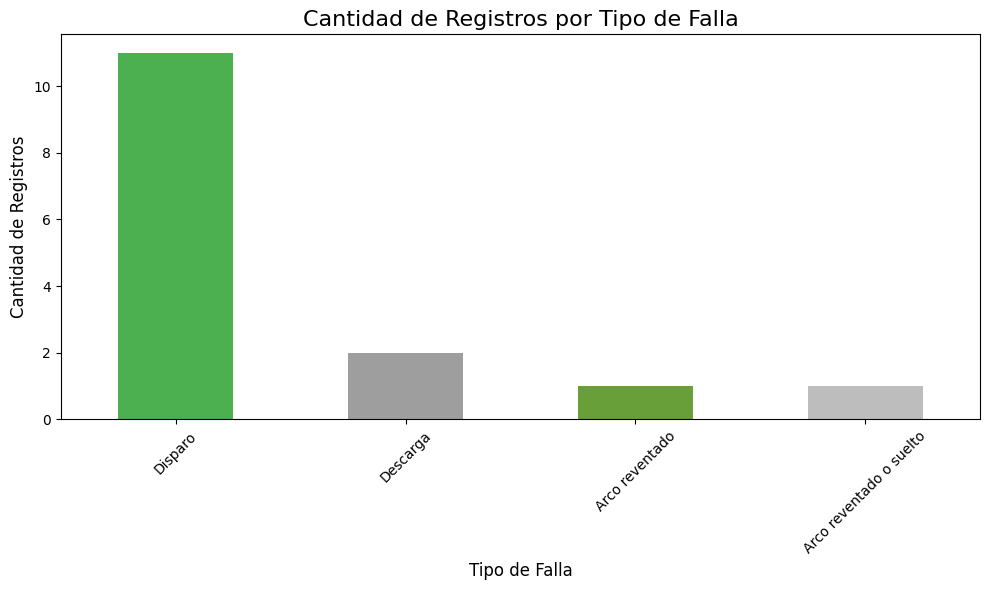

In [39]:
query="Construye un gráfico en el cual muestres la cantidad de registro por el tipo de falla"
path_plot="/content/image.jpg"
prompt=f"""{query}. Construye el gráfico de la forma más estética posible para mostrar a un usuario.
    Puedes utilizar los siguientes colores: verde y gris en diferentes tonalidades (si es necesario, utiliza más colores).
    Además, los títulos y ejes de los gráficos deben estar en español.
    Guarda la imagen en la ruta relativa {path_plot}.
    No ejecutes el comando plt.show().
    Siempre ejecuta el comando plt.tight_layout()."""

agent = create_pandas_dataframe_agent(
        ChatOpenAI(temperature=0, model="gpt-3.5-turbo"),
        eventos_muestras_filtered,
        verbose=True,
        agent_type="openai-functions",#prefix=descripcion_df,  # Añade la descripción al inicio del prompt #suffix=suffix_instrucciones.format(path_plot=path_plot),
        allow_dangerous_code=True,
        include_df_in_prompt=True,  # Incluye las primeras filas del DataFrame en el prompt
        )

response=agent.invoke(prompt)["output"]